Assignnement 2: Prediction and Classification

Due: Thursday, April 30, 2015 11:59 PM


# Introduction
Problem 3 is optional - for extra credit!
Problems 1 and 2 will be graded for the Lab 2.  


In this assignment you will be using regression and classification to explore different data sets.  

**First**: You will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression.  This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

!["Sabermetrics Science"](http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg)
http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg

**Second**: You will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**Third**: You will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [cars data set](https://archive.ics.uci.edu/ml/datasets/Automobile).  


## Load Python modules

In [780]:
# prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics).  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. You will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [781]:
### Your code here ###
teams=pd.read_csv('../lahman-csv_2014-02-14/Teams.csv')
players=pd.read_csv('../lahman-csv_2014-02-14/Batting.csv')
salaries=pd.read_csv('../lahman-csv_2014-02-14/Salaries.csv')
fielding=pd.read_csv('../lahman-csv_2014-02-14/Fielding.csv')
master=pd.read_csv('../lahman-csv_2014-02-14/Master.csv')

#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [782]:
### Your code here ###
players_salaries = master.merge(salaries,on='playerID', how='outer')[['playerID','nameGiven','nameLast','salary']]
medianSalaries = players_salaries.groupby(['playerID','nameGiven','nameLast']).median().reset_index()
medianSalaries.head()

playerID       nameGiven nameLast  salary
0  aardsda01     David Allan  Aardsma  419000
1  aaronha01     Henry Louis    Aaron     NaN
2  aaronto01      Tommie Lee    Aaron     NaN
3   aasedo01  Donald William     Aase  612500
4   abadan01   Fausto Andres     Abad  327000

#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [783]:
teams_filtered = teams.ix[teams['yearID']>=1947].ix[teams['G']==162]
teams_filtered['singles']=teams_filtered['H']-teams_filtered['2B']-teams_filtered['3B']-teams_filtered['HR']
teams_filtered['plateAppearance']=teams_filtered['AB']+teams_filtered['BB']
teams_filtered['singlesPPA']=teams_filtered['singles']/teams_filtered['plateAppearance']
teams_filtered['doublesPPA']=teams_filtered['2B']/teams_filtered['plateAppearance']
teams_filtered['triplesPPA']=teams_filtered['3B']/teams_filtered['plateAppearance']
teams_filtered['HRPPA']=teams_filtered['HR']/teams_filtered['plateAppearance']
teams_filtered['BBPPA']=teams_filtered['BB']/teams_filtered['plateAppearance']
stats=teams_filtered[['teamID','yearID','W','singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']]
stats.head()

teamID  yearID   W  singlesPPA  doublesPPA  triplesPPA     HRPPA  \
1366    LAA    1961  70    0.147748    0.035708    0.003604  0.030958   
1367    KC1    1961  61    0.164751    0.035982    0.007829  0.014993   
1377    NYA    1962  96    0.167148    0.038536    0.004656  0.031952   
1379    LAA    1962  86    0.159482    0.038027    0.005737  0.022455   
1381    CHA    1962  85    0.165797    0.040756    0.009129  0.014998   

         BBPPA  
1366  0.111548  
1367  0.096618  
1377  0.093770  
1379  0.098672  
1381  0.101076

#### Problem 1(d)

Is there a noticeable time trend in the rates computed computed in Problem 1(c)? 

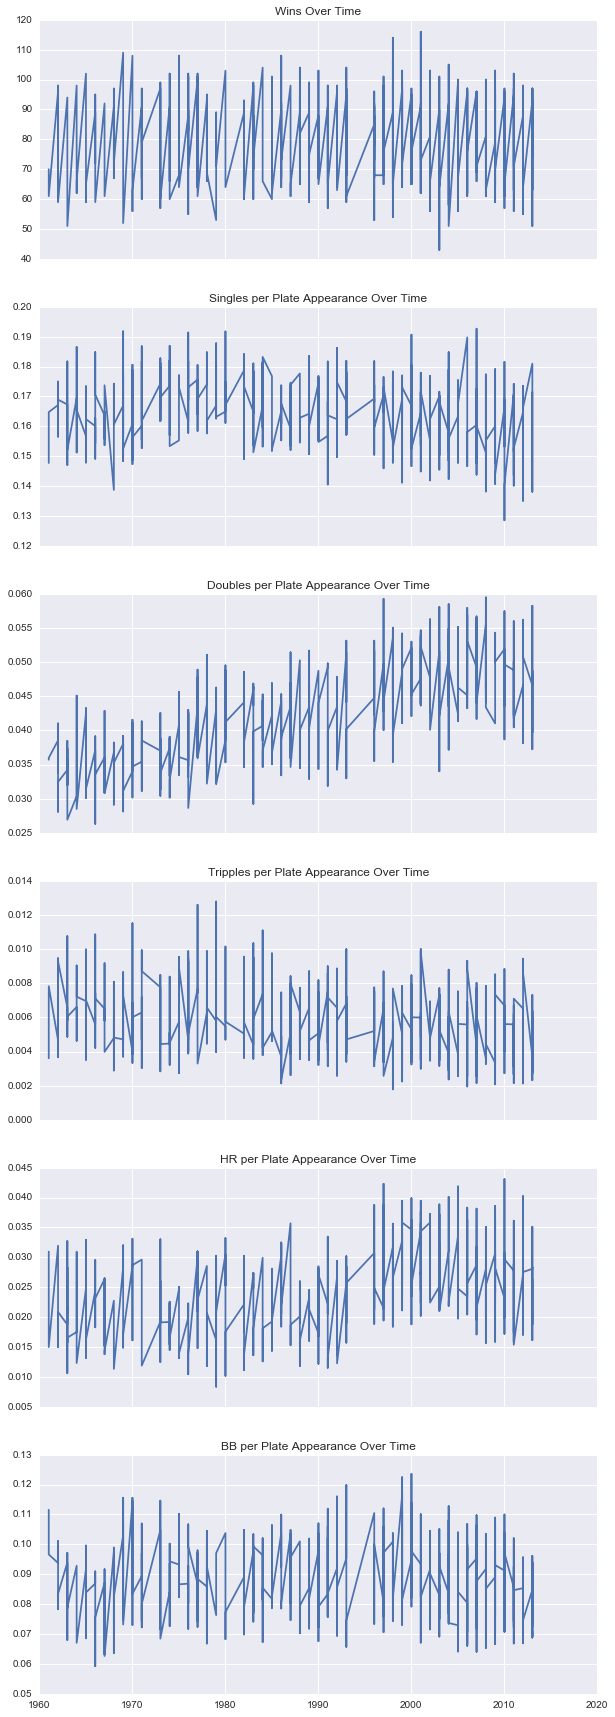

In [784]:
### Your code here ###
f, axarr = plt.subplots(6, sharex=True, )
f.set_size_inches(10,30)
axarr[0].plot(stats['yearID'], stats['W'])
axarr[0].set_title('Wins Over Time')

axarr[1].plot(stats['yearID'], stats['singlesPPA'])
axarr[1].set_title('Singles per Plate Appearance Over Time')

axarr[2].plot(stats['yearID'], stats['doublesPPA'])
axarr[2].set_title('Doubles per Plate Appearance Over Time')

axarr[3].plot(stats['yearID'], stats['triplesPPA'])
axarr[3].set_title('Tripples per Plate Appearance Over Time')

axarr[4].plot(stats['yearID'], stats['HRPPA'])
axarr[4].set_title('HR per Plate Appearance Over Time')

axarr[5].plot(stats['yearID'], stats['BBPPA'])
axarr[5].set_title('BB per Plate Appearance Over Time')

- Doubles per plate appearnce rate has consistently increased over time
- Home runs per plate appearance has had a sudden increase from 1995 onwards

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [786]:
### Your code here ###
stats_mean_per_year=pd.DataFrame()
stats_normalized=pd.DataFrame()
stats_mean_per_year[['yearID','singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']]\
        =stats.groupby('yearID', as_index=False).mean()[['yearID','singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']]
stats_merged = stats_mean_per_year.merge(stats, on='yearID')
stats_normalized= pd.DataFrame(stats_merged.ix[:,['singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']].values-\
stats_merged.ix[:,['singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']].values, \
                               columns=['singlesPPA_adj','doublesPPA_adj','triplesPPA_adj','HRPPA_adj','BBPPA_adj'])
stats_normalized [['yearID','teamID', 'W']]= stats_merged[['yearID','teamID', 'W']]
stats_normalized.head()

singlesPPA_adj  doublesPPA_adj  triplesPPA_adj  HRPPA_adj  BBPPA_adj  \
0       -0.008502       -0.000137       -0.002113   0.007983   0.007465   
1        0.008502        0.000137        0.002113  -0.007983  -0.007465   
2        0.001516        0.002683       -0.002121   0.008141   0.005180   
3       -0.006150        0.002174       -0.001040  -0.001356   0.010082   
4        0.000165        0.004904        0.002352  -0.008813   0.012486   

   yearID teamID   W  
0    1961    LAA  70  
1    1961    KC1  61  
2    1962    NYA  96  
3    1962    LAA  86  
4    1962    CHA  85

#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [817]:
### Your code here ###
from sklearn import linear_model
from itertools import combinations

regr = linear_model.LinearRegression()
# Trying Train the model using the training sets
test_error={}
# Going through all feature combinations to choose the ones with the lowerst error in the test set
for n in range(1,6):
    feature_selected = combinations(['singlesPPA_adj','doublesPPA_adj','triplesPPA_adj','HRPPA_adj','BBPPA_adj'],n)
    for rates in feature_selected:
        X_train=stats_normalized.ix[stats_normalized['yearID']<=2002,list(rates)]
        y_train=stats_normalized.ix[stats_normalized['yearID']<=2002,['W']]
        regr.fit(X_train, y_train)
        # The mean square error
        X_test = stats_normalized.ix[stats_normalized['yearID']>2002,list(rates)]
        y_test = stats_normalized.ix[stats_normalized['yearID']>2002,['W']]
        test_error [rates] = np.mean((regr.predict(X_test) - y_test) ** 2)[0]

# Selecting the feature combinations which yields the lowest error on the test set
selected_features=min(test_error, key=test_error.get)
X_train=stats_normalized.ix[stats_normalized['yearID']<=2002,list(selected_features)]
y_train=stats_normalized.ix[stats_normalized['yearID']<=2002,['W']]
regr.fit(X_train, y_train)
X_test = stats_normalized.ix[stats_normalized['yearID']>2002,list(selected_features)]
y_test = stats_normalized.ix[stats_normalized['yearID']>2002,['W']]

# The mean square error on the train and test set
print("Residual sum of squares on test set: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))

print("Residual sum of squares on training set: %.2f"
      % np.mean((regr.predict(X_train) - y_train) ** 2))

Residual sum of squares on test set: 82.63
Residual sum of squares on training set: 77.40


** Your answer here: **

In [790]:
# Predicting the OPW based on the trained model
stats_normalized['OPW']=regr.predict(stats_normalized.ix[:,\
                                ['singlesPPA_adj','doublesPPA_adj','triplesPPA_adj','HRPPA_adj','BBPPA_adj']]).round()
stats_normalized.head()

singlesPPA_adj  doublesPPA_adj  triplesPPA_adj  HRPPA_adj  BBPPA_adj  \
0       -0.008502       -0.000137       -0.002113   0.007983   0.007465   
1        0.008502        0.000137        0.002113  -0.007983  -0.007465   
2        0.001516        0.002683       -0.002121   0.008141   0.005180   
3       -0.006150        0.002174       -0.001040  -0.001356   0.010082   
4        0.000165        0.004904        0.002352  -0.008813   0.012486   

   yearID teamID   W  OPW  
0    1961    LAA  70   85  
1    1961    KC1  61   77  
2    1962    NYA  96   91  
3    1962    LAA  86   82  
4    1962    CHA  85   85

#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

In [818]:
### Your code here ###
# Calculating the plateAppearance and singles for each player
players['plateAppearance']=players['AB']+players['BB']
players_filtered = players.ix[players['yearID']>=1947].ix[players['G']>=162].ix[players['plateAppearance']>=500]
players_filtered['singles']=players_filtered['H']-players_filtered['2B']-players_filtered['3B']-players_filtered['HR']

# calculating the rates for each player
players_filtered['singlesPPA']=players_filtered['singles']/players_filtered['plateAppearance']
players_filtered['doublesPPA']=players_filtered['2B']/players_filtered['plateAppearance']
players_filtered['triplesPPA']=players_filtered['3B']/players_filtered['plateAppearance']
players_filtered['HRPPA']=players_filtered['HR']/players_filtered['plateAppearance']
players_filtered['BBPPA']=players_filtered['BB']/players_filtered['plateAppearance']
playerstats_raw=players_filtered[['playerID','yearID','singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']]

###Removing the mean per year such that the average of all rates per year per player is zero####
playerstats_raw_mean_per_year=pd.DataFrame()
playerstats_raw_mean_per_year[['yearID','singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']]\
        =playerstats_raw.groupby('yearID', as_index=False).mean()[['yearID','singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']]
playerstats_merged = playerstats_raw_mean_per_year.merge(playerstats_raw, on='yearID')
playerstats= pd.DataFrame(playerstats_merged.ix[:,['singlesPPA','doublesPPA','triplesPPA','HRPPA','BBPPA']].values-\
playerstats_merged.ix[:,['singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']].values, \
                               columns=['singlesPPA_adj','doublesPPA_adj','triplesPPA_adj','HRPPA_adj','BBPPA_adj'])
playerstats[['yearID','playerID']]= playerstats_merged[['yearID','playerID']]

Show the head of the `playerstats` DataFrame. 

In [819]:
### Your code here ###
playerstats.head()

singlesPPA_adj  doublesPPA_adj  triplesPPA_adj  HRPPA_adj  BBPPA_adj  \
0       -0.048011        0.007005       -0.006953   0.041146   0.074385   
1        0.033678       -0.011532       -0.002601  -0.019174  -0.044619   
2        0.015609        0.017048       -0.000036  -0.013719  -0.022237   
3       -0.001277       -0.012520        0.009591  -0.008253  -0.007528   
4        0.007904       -0.001749       -0.006844   0.015932  -0.031137   

   yearID   playerID  
0    1961  colavro01  
1    1961  richabo01  
2    1961  robinbr01  
3    1961   woodja01  
4    1962  cepedor01

#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the avaerage of the rates by year (a more correct way is to go back to the totals). 

In [794]:
### Your code here ###
# calculating the start year and end year of each player based on the min and max years in playerstats DF
player_year=playerstats[['yearID','playerID']].groupby('playerID', as_index=False).min().rename(columns={'yearID':'yearStarted'})
player_year['yearEnded']=playerstats[['yearID','playerID']].groupby('playerID', as_index=False).max()['yearID']
# calculate the mean rate for each player
players_mean_rate = playerstats[['playerID','singlesPPA_adj','doublesPPA_adj','triplesPPA_adj','HRPPA_adj','BBPPA_adj']]\
.groupby('playerID', as_index=False).mean().rename(columns={'singlesPPA_adj':'singlesPPA_ave',\
     'doublesPPA_adj':'doublesPPA_ave','triplesPPA_adj':'triplesPPA_ave','HRPPA_adj':'HRPPA_ave','BBPPA_adj':'BBPPA_ave'})
# merge the DF with player_year DF to get the salary, name,... information
playerLS=player_year.merge(players_mean_rate, on='playerID')

Show the head of the `playerLS` DataFrame. 

In [793]:
### Your code here ###
playerLS.head()

playerID  yearStarted  yearEnded  singlesPPA_ave  doublesPPA_ave  \
0  abreubo01         2001       2005       -0.022295        0.008226   
1  abreubo01         2001       2005       -0.022295        0.008226   
2  abreubo01         2001       2005       -0.022295        0.008226   
3  abreubo01         2001       2005       -0.022295        0.008226   
4  abreubo01         2001       2005       -0.022295        0.008226   

   triplesPPA_ave  HRPPA_ave  BBPPA_ave  OPW  nameGiven nameLast   salary POS  
0       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  LF  
1       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  OF  
2       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  RF  
3       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  CF  
4       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  LF

#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [796]:
### Your code here ###
# we can use the same trained model on teams to predict player's OPW as we can interpret each player as a team with 9 similar player
playerLS['OPW']=regr.predict(playerLS.ix[:,\
                                ['singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']]).round()
playerLS.head()

playerID  yearStarted  yearEnded  singlesPPA_ave  doublesPPA_ave  \
0  abreubo01         2001       2005       -0.022295        0.008226   
1  allendi01         1964       1964       -0.004268        0.015058   
2  alomasa01         1970       1971        0.011155       -0.008823   
3   alouma01         1969       1969        0.077250        0.015560   
4  bagweje01         1992       1999       -0.026592        0.007757   

   triplesPPA_ave  HRPPA_ave  BBPPA_ave  OPW  
0       -0.002379  -0.003980   0.054759   95  
1        0.010584   0.012612   0.014706  116  
2       -0.002639  -0.012807  -0.030193   53  
3        0.001520  -0.033637  -0.059120   73  
4       -0.001099   0.012338   0.057971  110

#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF), first name, last name and median salary. 

In [797]:
### Your code here ###
#restricting the POS column to positions (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF)#
POS_DF = fielding.ix[fielding['POS'].isin(['C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF','DH', 'OF'])][['playerID','POS']]
playerLS = playerLS.merge(medianSalaries, on='playerID').merge(POS_DF, on='playerID')

- **Assumptions: To get the player's position I used the fielding DF but I didn't restrict the fielding DF to year>1947 and G>162 and used the whole fielding data frame. The reason is if we restrict the fielding DF, we won't have players for some of the positions.**

Show the head of the `playerLS` DataFrame. 

In [798]:
### Your code here ###
playerLS.head()

playerID  yearStarted  yearEnded  singlesPPA_ave  doublesPPA_ave  \
0  abreubo01         2001       2005       -0.022295        0.008226   
1  abreubo01         2001       2005       -0.022295        0.008226   
2  abreubo01         2001       2005       -0.022295        0.008226   
3  abreubo01         2001       2005       -0.022295        0.008226   
4  abreubo01         2001       2005       -0.022295        0.008226   

   triplesPPA_ave  HRPPA_ave  BBPPA_ave  OPW  nameGiven nameLast   salary POS  
0       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  LF  
1       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  OF  
2       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  RF  
3       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  CF  
4       -0.002379   -0.00398   0.054759   95  Bob Kelly    Abreu  9000000  LF

#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins. 

In [799]:
### Your code here ###
playerLS_subset=playerLS.ix[playerLS['yearStarted']<=2002].ix[playerLS['yearEnded']>=2003].ix[playerLS['yearEnded']\
                                                                                    -playerLS['yearStarted']>=3]
playerLS_subset_no_dup=playerLS_subset.drop('POS',1).drop_duplicates().sort('OPW')
playerLS_subset_no_dup

playerID  yearStarted  yearEnded  singlesPPA_ave  doublesPPA_ave  \
4920  tejadmi01         2001       2006        0.011184        0.003086   
0     abreubo01         2001       2005       -0.022295        0.008226   
4135  rodrial01         2001       2005        0.001807       -0.009283   

      triplesPPA_ave  HRPPA_ave  BBPPA_ave  OPW           nameGiven  \
4920       -0.003607   0.004192  -0.027989   74       Miguel Odalis   
0          -0.002379  -0.003980   0.054759   95           Bob Kelly   
4135       -0.003888   0.030119   0.017702  108  Alexander Emmanuel   

       nameLast    salary  
4920     Tejada   5062500  
0         Abreu   9000000  
4135  Rodriguez  22000000

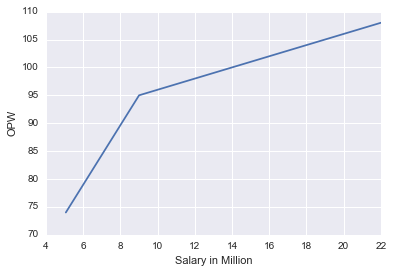

In [800]:
plt.plot(playerLS_subset_no_dup['salary']/1000000,playerLS_subset_no_dup['OPW'])
plt.xlabel('Salary in Million')
plt.ylabel('OPW')

**The higher the salary the higher the number of predicted wins. So there seems to be a strong correlation between the player's salary and his number of wins**

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [802]:
### Your code here ###
POS=['C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH', 'OF']
dream_team={}
# fist pick the player with the highest OPW for each position
for pos in POS:
    dream_team[pos]=playerLS.ix[playerLS['POS']==pos].dropna().sort('OPW', ascending=False).drop_duplicates().reset_index()\
                                    [['playerID','OPW','salary']].ix[0]

# Calculate the total salary of the initial picked players
salary_sum=sum([player['salary'] for player in dream_team.values()])

# if the initial total salary is greater than 20 millions, then cycle through positions and pick the next top OPW player
# and check the salary again and break the loop if the salary is less than 20 millions
i=1
while (salary_sum>20000000):
    for pos in POS:
        dream_team[pos]=playerLS.ix[playerLS['POS']==pos].dropna().sort('OPW', ascending=False).drop_duplicates()\
                                                .reset_index()[['playerID','OPW','salary']].ix[i]
        salary_sum=sum([player['salary'] for player in dream_team.values()])
        if (salary_sum<=20000000):
            break

    i+=1
print "Total Salary of dream team is : " ,sum([player['salary'] for player in dream_team.values()])
print "Total OPW of dream team is : " ,sum([player['OPW'] for player in dream_team.values()])

Total Salary of dream team is :  18299395.5
Total OPW of dream team is :  980.0


#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples HR or BB?

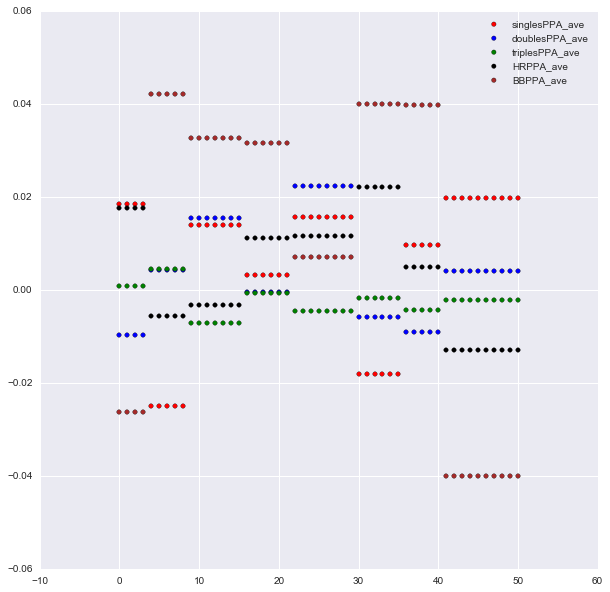

In [809]:
# plotting all 5 rates for the players in the dream team
colors=['r','b','g','k','brown']
i=0
plt.figure(figsize=(10,10))
for rate in ['singlesPPA_ave','doublesPPA_ave','triplesPPA_ave','HRPPA_ave','BBPPA_ave']:
    # finding the playerID of the dream team members and get their stats from playerLS
    dearm_player=playerLS.ix[playerLS['playerID'].isin([player['playerID'] for player in dream_team.values()])]\
             .drop_duplicates().reset_index()
    plt.scatter(dearm_player.index, dearm_player[rate], c=colors[i], label=rate)
    plt.legend()
    i+=1

** Your answer here: **
#### Based on the figure above, the players of the dream team outperform in BB (highest rates in BBPPA_ave)

### Use one of the classification methods to predict whether a player will be an Allstar?

In [811]:
### Your code here ###
# creating a new DF playerLS_all_star with the allstar flag (GP) from the AllstarFull.csv file
allstar=pd.read_csv('../lahman-csv_2014-02-14/AllstarFull.csv')
playerLS_all_star=playerLS.merge(allstar[['playerID','GP']], on='playerID', how='inner').drop(['playerID','nameGiven','nameLast'],1)
playerLS_all_star.head()

yearStarted  yearEnded  singlesPPA_ave  doublesPPA_ave  triplesPPA_ave  \
0         2001       2005       -0.022295        0.008226       -0.002379   
1         2001       2005       -0.022295        0.008226       -0.002379   
2         2001       2005       -0.022295        0.008226       -0.002379   
3         2001       2005       -0.022295        0.008226       -0.002379   
4         2001       2005       -0.022295        0.008226       -0.002379   

   HRPPA_ave  BBPPA_ave  OPW   salary POS  GP  
0   -0.00398   0.054759   95  9000000  LF   1  
1   -0.00398   0.054759   95  9000000  LF   1  
2   -0.00398   0.054759   95  9000000  OF   1  
3   -0.00398   0.054759   95  9000000  OF   1  
4   -0.00398   0.054759   95  9000000  RF   1

In [813]:
from sklearn import preprocessing
# determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
real_or_str=playerLS_all_star.applymap(np.isreal).all(0)
non_num_feature=real_or_str[~real_or_str].keys()
le = preprocessing.LabelEncoder()
for col in non_num_feature:
    #transform the non-numeric columns to numeric values using 
    #LabelEncoder method from SKLearn#
    playerLS_all_star[col]=le.fit_transform(playerLS_all_star[col])

# filling in NaN values with the mean value of the feature    
playerLS_all_star=playerLS_all_star.fillna(playerLS_all_star.mean())

In [815]:
from sklearn.ensemble import RandomForestClassifier

X_features=playerLS_all_star.ix[:,:-1]
y_target=playerLS_all_star['GP'].astype(int)

# splitting the data to train/test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

# Using a RandomForestClassifier to predict if a player will be an Allstar
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)

print "The score of the randome forrest classifier (to predict all star player) on the test set is:" ,clf.score(X_test,y_test)

The score of the randome forrest classifier (to predict all star player) on the test set is: 0.903990517582


## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

- There's an increase trend in Doubles per plate appearnce rate over time
- Home runs per plate appearance has had a sudden increase from in 1995.
- Singles, double, triples, HR, and BB rates are useful features that can be used in precise prediction of a team's wins.
- There's a strong correlation between the salary of a player and the number of wins (predicted wins) for the same player.
- Based on the averate Singles, double, triples, HR, and BB rates, one can create a dream team which yields the highest number of wins for the given total salary limitatiosn.
- The players with the highest OPW (dream team members) tends to have the higher BB rates and lower singles rate.
- Based on the averate Singles, double, triples, HR, and BB rates, one can predict with high accuracy if a player is going to be an All star player.

# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem you will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists. 
For the Iris data set  sklearn provides an extra function to load it - since it is one of the very commonly used data sets.

In [820]:
#load the iris data set
from sklearn import datasets
iris = datasets.load_iris()
iris_features = iris.data
iris_target = iris.target

#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [821]:
### Your code here ###
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_features, iris_target, test_size=0.33, random_state=33)
print "size of train set (features) is: ", X_train.shape
print "size of train set (targets) is: ", y_train.shape
print "size of test set (features) is: ", X_test.shape
print "size of test set (targets) is: ", y_test.shape

size of train set (features) is:  (100, 4)
size of train set (targets) is:  (100,)
size of test set (features) is:  (50, 4)
size of test set (targets) is:  (50,)


#### Problem 2(b) 

 Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For your convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [822]:
### Your code here ###
from sklearn.neighbors import KNeighborsClassifier
from sklearn import grid_search
parameters = {'n_neighbors':range(1,21)}
neigh = KNeighborsClassifier()
clf = grid_search.GridSearchCV(neigh, parameters, cv=10)
clf.fit(X_train, y_train)
print "The best selected number of neighbors is: ", clf.best_params_

The best selected number of neighbors is:  {'n_neighbors': 7}


#### Problem 2(c)

Visualize the result by plotting the score results versus values for $k$. 

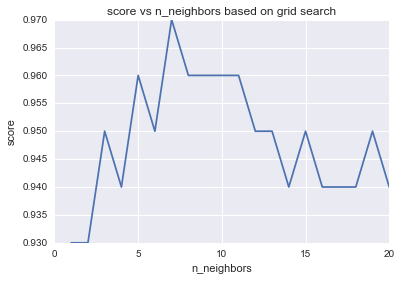

In [826]:
### Your code here ###
plt.plot(range(1,21),[scores[1] for scores in clf.grid_scores_])
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.title('score vs n_neighbors based on grid search')

Verify that the grid search has indeed chosen the right parameter value for $k$.

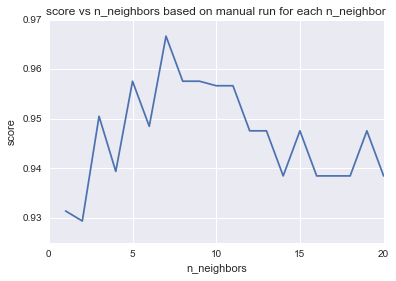

In [828]:
### Your code here ###
from sklearn import cross_validation
# manual run of KNN for each n_neighbors and comparing the error to choose the best parameter
knn_score=[]
for i in range(1,21):
    neigh = KNeighborsClassifier(n_neighbors=i)
    knn_score.append(np.mean(cross_validation.cross_val_score(neigh, X_train, y_train, cv=10)))
    
plt.plot(range(1,21),knn_score)
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.title('score vs n_neighbors based on manual run for each n_neighbor')

**based on the plots above we can see that grid search has chosen the correct parameters (n_neighbors=7) to get the highest possible score.**

#### Problem 2(d)

Test the performance of our tuned KNN classifier on the test set.

In [829]:
### Your code here ###
neigh = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'])
clf.fit(X_train, y_train)
print "The score of the tuned KNN (with best n_neighbors parameter) on the test set is:" ,clf.score(X_test,y_test)

The score of the tuned KNN (with best n_neighbors parameter) on the test set is: 0.98


## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

- grid_search function can be used to quickly and effectively choose the best parameter for any classifier/regressor.
- KNN classifier yields very high accuracy on samll datasets like IRIS dataset.

## Problem 3: Supervised Learning - Estimating Auto pricing using Linear Regression and Regression Trees

##### Download the UCI ML automobile dataset. (https://archive.ics.uci.edu/ml/datasets/Automobile)

In [122]:
### Your code here ###
#!mkdir ../autos
!curl  -o "../autos/imports-85.data" https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data
!curl  -o "../autos/imports-85.names" https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
!curl  -o "../autos/misc" https://archive.ics.uci.edu/ml/machine-learning-databases/autos/misc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25936  100 25936    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4747  100  4747    0     0  19556      0 --:--:-- --:--:-- --:--:-- 19534
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3757  100  3757    0     0  23061      0 --:--:-- --:--:-- --:--:-- 23191


#### Find the mostimportant features

In [946]:
### Your code here ###
attr_names= ['symboling',
 'normalized-losses',
 'make',
 'fuel-type',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-type',
 'num-of-cylinders',
 'engine-size',
 'fuel-system',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price']

cars_DF = pd.read_csv("../autos/imports-85.data", names=attr_names).replace(to_replace='?', value=np.nan).convert_objects(convert_numeric=True)
cars_DF.head()

symboling  normalized-losses         make fuel-type aspiration  \
0          3                NaN  alfa-romero       gas        std   
1          3                NaN  alfa-romero       gas        std   
2          1                NaN  alfa-romero       gas        std   
3          2                164         audi       gas        std   
4          2                164         audi       gas        std   

  num-of-doors   body-style drive-wheels engine-location  wheel-base  ...    \
0          two  convertible          rwd           front        88.6  ...     
1          two  convertible          rwd           front        88.6  ...     
2          two    hatchback          rwd           front        94.5  ...     
3         four        sedan          fwd           front        99.8  ...     
4         four        sedan          4wd           front        99.4  ...     

   engine-size  fuel-system  bore  stroke compression-ratio horsepower  \
0          130         mpfi  3.47    2.68                 9        111   
1          130         mpfi  3.47    2.68                 9        111   
2          152         mpfi  2.68    3.47                 9        154   
3          109         mpfi  3.19    3.40                10        102   
4          136         mpfi  3.19    3.40                 8        115   

   peak-rpm city-mpg  highway-mpg  price  
0      5000       21           27  13495  
1      5000       21           27  16500  
2      5000       19           26  16500  
3      5500       24           30  13950  
4      5500       18           22  17450  

[5 rows x 26 columns]

In [947]:
# fillinf in NaN values with t
# find the non-numeric columns and converting them to numeric using SKLearn LabelEncoder() method
real_or_str=cars_DF.applymap(np.isreal).all(0)
non_num_feature=real_or_str[~real_or_str].keys()
le = preprocessing.LabelEncoder()
for col in non_num_feature:
    #2- fill the NaN in non-numeric columns with the most used element#
    cars_DF[col].fillna(cars_DF[col].describe().top, inplace=True)
    #3- transform the non-numeric columns to numeric values using 
    #LabelEncoder method from SKLearn#
    cars_DF[col]=le.fit_transform(cars_DF[col])

#Filling in NaN values of numeric features with the mean value of the feature
cars_DF=cars_DF.fillna(cars_DF.mean())

In [948]:
# fit a RandomForestRegressor to determine the most important feature
from sklearn.ensemble import RandomForestRegressor
X_features=cars_DF.ix[:,:-1]
y_target=cars_DF['price']
clf = RandomForestRegressor(n_estimators=25)
clf.fit(X_features, y_target)

print "The most important feature is: ", attr_names[np.argmax(clf.feature_importances_)]

The most important feature is:  engine-size


**The most important feature seems to be the feature with the large range of magnitudes. So this can't be trusted and we might need to normalize the data to the same range and re-apply random forest regressor to determine if 'engine-size' is indeed the most important feature which I will do in the next 3 sections.**

#### Using 10-fold cross validation separate the test and training data sets

In [949]:
### Your code here ###
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=None)

**Assumptions**: I won't be using the splitted test/train directly (10 times). Instead I will use the cross_val_score method which implicitly split the test/train at each cross validation stage (fold) and calculate score for each fold seperately.

Normalize the data

In [950]:
### Your code here ###
X_train_normalized= preprocessing.scale(X_train)
X_test_normalized= preprocessing.scale(X_test)
X_features_normalized=preprocessing.scale(X_features)

In [951]:
#reapplying the randomforestregressor on the normalized the data to get the most important feature#
clf = RandomForestRegressor(n_estimators=25)
clf.fit(X_features_normalized, y_target)

print "The most important feature after normalization is: ", attr_names[np.argmax(clf.feature_importances_)]

The most important feature after normalization is:  engine-size


**We can see that even after normalizations, curb-weight is the most important feature in predicting the price of a car**

### Start with a linear model and evaluate how well it can predict the price variable

In [953]:
### Your code here ###
from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_normalized, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % np.mean(cross_val_score(regr, X_features_normalized, y_target, cv=10)))


Variance score: -0.25


### Try using Ridge regression and evaluate the result of the 10-fold cross-validation

In [954]:
### Your code here ###
from sklearn.linear_model import Ridge
clf = linear_model.Ridge()

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % np.mean(cross_val_score(clf, X_features_normalized, y_target, cv=10)))


Variance score: -0.18


### Train the Regression Tree and evaluate using 10-fold cross validation; Specify the parapmeters used and how you changed them to increase the accuracy;  

In [999]:
### Your code here ###
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
regressor = DecisionTreeRegressor(random_state=0, max_features='auto', max_depth=6,min_samples_split=30, min_samples_leaf=4)

print "Average 10 fold CV score is :", np.mean(cross_val_score(regressor, X_features, y_target, cv=10))

Average 10 fold CV score is : 0.532673693895


- changed the maximum number of features from n_features to sqrt(n_features) to avoid overfitting and improving the test score.
- changed the max_depth of the tree to 6 to avoid overfitting and improving the test score.
- changed the minimum number of samples required to split an internal node from 2 to 50 to avoide over-splitting and overfitting.
- increased the number of required samples at a leaf node to 4.

### Discussion for Problem 3  Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.Compare all three aproaches and discuss your findings in 100 words or less

- Choosing the most important feature can be done using RandomForestRegressor, however, due to the different range of different features, the feature selection might be biased towards the feature with larger range. So normalization can help in these situations.
- cross_val_score() method can be used directly to both split data into train/test and compute the test score on the model fitted to the train at the same time.
- tuning the performance of any classifier/regressor can be done by sweeping through all possible parameter of the classifier/regressor. however, having some idea about the idea at hands and initial results of a simple classifier can help in giving direction of changing these parameters to fine-tune the classifier/regressor.